#### Libraries

In [179]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from yellowbrick.cluster import KElbowVisualizer

#### Settings

In [182]:
# Display all rows
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# Notebook random state
random_state = 421

# Set visuals to default
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Question 2

#### Generate Data

In [142]:
# Generate random multidimensional data with 1000 samples and 15 features
X_2, y_2 = make_classification(n_samples=1000, 
                               n_features=15,
                               n_classes=2,
                               n_informative=2,
                               random_state=random_state)
df_2 = pd.DataFrame(X_2)

#### K-means from scratch

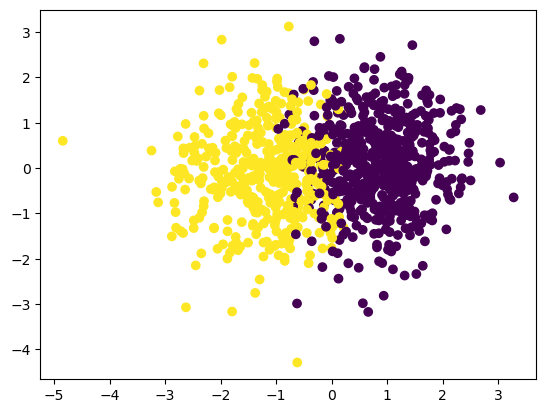

In [183]:
def KMeans(X, n_clusters, max_iter=1000, random_state=random_state):
    """
    X: numpy array with shape (num_samples, num_features)
    n_clusters: number of clusters to form
    max_iter: maximum number of iterations of the K-Means algorithm
    """
    
    random.seed(random_state)
    
    num_samples, num_features = X.shape
    
    # Initialize cluster centroids
    centroids = X[np.random.choice(num_samples, n_clusters, replace=False), :]
    
    for i in range(max_iter):
        # Calculate Euclidean distance between each sample and centroids
        distances = np.zeros((num_samples, n_clusters))
        for j in range(n_clusters):
            distances[:, j] = np.linalg.norm(X - centroids[j, :], axis=1)
        
        # Assign each sample to the nearest centroid
        cluster_assignment = np.argmin(distances, axis=1)
        
        # Recalculate centroids as mean of samples assigned to each cluster
        for j in range(n_clusters):
            centroids[j, :] = np.mean(X[cluster_assignment == j, :], axis=0)
    
    return cluster_assignment, centroids

labels = KMeans(X_2, 2)
plt.scatter(X_2[:, 0], X_2[:, 1], c=labels[0])
plt.show()

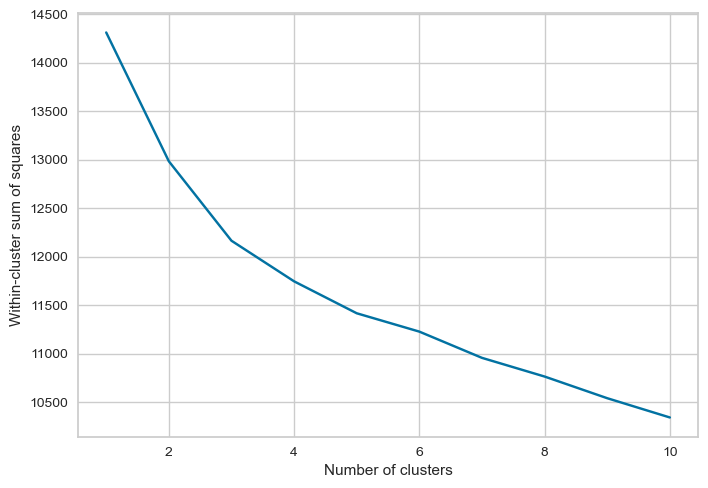

In [177]:
def WCSS(X, labels, centroids):
    """
    Calculate within-cluster sum of squares
    """
    num_samples = X.shape[0]
    wcss = 0
    for i in range(num_samples):
        sample = X[i, :]
        centroid = centroids[labels[i]]
        wcss += np.linalg.norm(sample - centroid) ** 2
    return wcss

k_values = range(1, 11)
wcss_values = []
for k in k_values:
    labels, centroids = KMeans(X_2, k)
    wcss = WCSS(X_2, labels, centroids)
    wcss_values.append(wcss)

plt.plot(k_values, wcss_values)
plt.xlabel("Number of clusters")
plt.ylabel("Within-cluster sum of squares")
plt.show()